In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense, BatchNormalization, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau


In [20]:
df = pd.read_csv('nyc_subway_ml_data.csv')
# dropped the weather as it decreased the accuracy of the model 
df.drop(['temp', 'precip', 'is_raining'], axis = 1, inplace = True)

# one hote enoding - station, borough
df = pd.get_dummies(df, columns = ['station'], prefix = 'sta')
df = pd.get_dummies(df, columns = ['borough'], prefix = 'boro')
df= df.drop('transaction_time', axis = 1)

oh_cols = [c for c in df.columns if c.startswith('boro_') or c.startswith('sta_')]
df[oh_cols] = df[oh_cols].astype('float32')

# reformat chronological data 
# with just integers, the model will consider weekday 1 and weekday 6 unrelated
df['hour_sin'] = np.sin(2 * np.pi * df['hour'] / 24)
df['hour_cos'] = np.cos(2 * np.pi * df['hour'] / 24)

df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)

df['weekday_sin'] = np.sin(2 * np.pi * df['weekday'] / 7)
df['weekday_cos'] = np.cos(2 * np.pi * df['weekday'] / 7)

col_X = ['hour_sin', 'hour_cos', 'month_sin', 'month_cos', 
         'weekday_sin', 'weekday_cos', 'isweekend', 'is_rush_hr', 'is_holiday', 
         'hr_lag', 'day_lag', 'week_lag']

scale_X = StandardScaler()
X_ss = scale_X.fit_transform(df[col_X])
X_oh = df[oh_cols].values
X_all = np.hstack([X_ss, X_oh])

# Scaling y values
y_none = df['entry_per_hour'].values
scale_y = MinMaxScaler()
y_scaled = scale_y.fit_transform(df[['entry_per_hour']])

# split data
train_all = df['month'] <= 10
test_all = df['month'] > 10

# split train / test
X_train = X_all[train_all]
X_test = X_all[test_all]

y_train_rf = y_none[train_all]
y_test_rf = y_none[test_all]

y_train_nn = y_scaled[train_all]
y_test_nn = y_scaled[test_all]

print(f"X_train shape: {X_train.shape}")
print(f"X_test shape:  {X_test.shape}")
print(f"y_train_rf shape: {y_train_rf.shape}")
print(f"y_test_rf shape:  {y_test_rf.shape}")

X_train shape: (356400, 66)
X_test shape:  (73200, 66)
y_train_rf shape: (356400,)
y_test_rf shape:  (73200,)


In [21]:
# random forest regressor
rf = RandomForestRegressor(n_estimators = 100, n_jobs = -1, random_state = 67)
rf.fit(X_train, y_train_rf)
pred = rf.predict(X_test)

mse = mean_squared_error(y_test_rf, pred)
rmse = np.sqrt(mse) 
mae = mean_absolute_error(y_test_rf, pred)
r2 = r2_score(y_test_rf, pred)

print(f'R2 Score (Accuracy): {r2:.4f}') 
print(f'RMSE: {rmse:.4f}')
print(f'MAE:  {mae:.4f}')
print(f'MSE: {mse:.4f}')

R2 Score (Accuracy): 0.9656
RMSE: 291.3857
MAE:  122.6633
MSE: 84905.6525


/var/folders/8q/3bk4mhcd2l38k0_tbmtbbsv80000gn/T/ipykernel_37484/443224944.py:9: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='Importance', y='Feature', data=fi_df.head(20), palette='viridis')


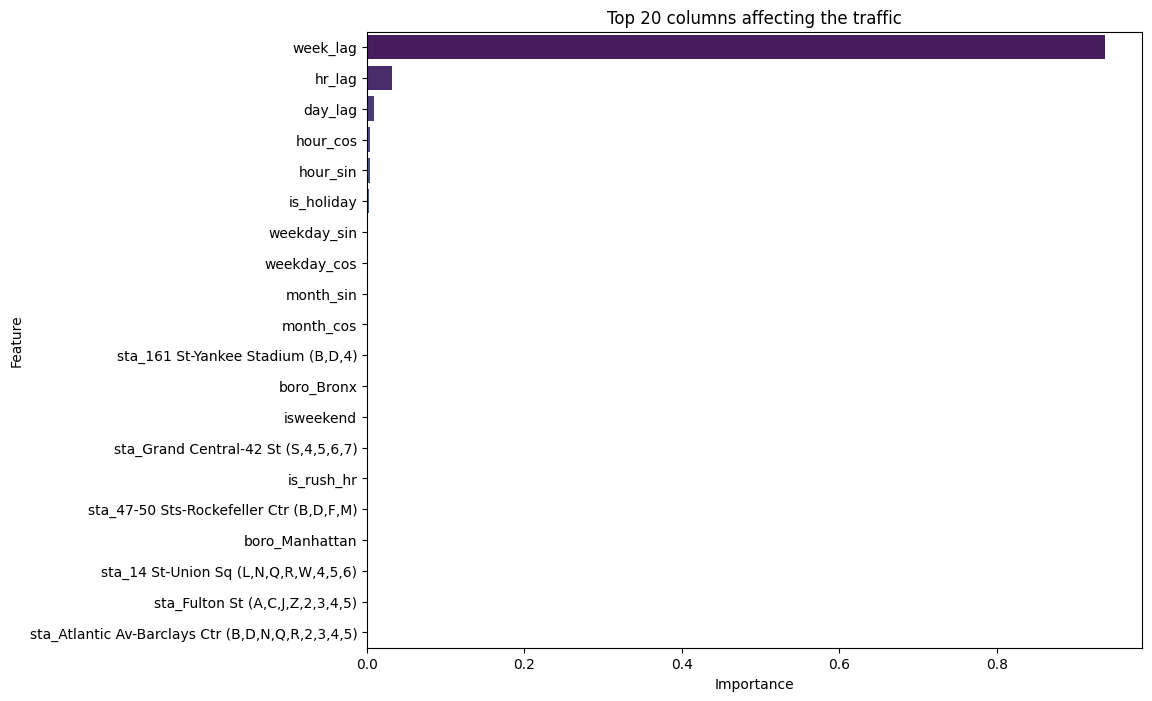

In [22]:
ohe_col_names = list(df.columns[df.columns.str.startswith('sta_')]) + \
                list(df.columns[df.columns.str.startswith('boro_')])
all_feature_names = col_X + ohe_col_names

fi_df = pd.DataFrame({'Feature': all_feature_names, 'Importance': rf.feature_importances_})
fi_df = fi_df.sort_values(by='Importance', ascending=False)

plt.figure(figsize=(10, 8))
sns.barplot(x='Importance', y='Feature', data=fi_df.head(20), palette='viridis')
plt.title('Top 20 columns affecting the traffic')
plt.show()

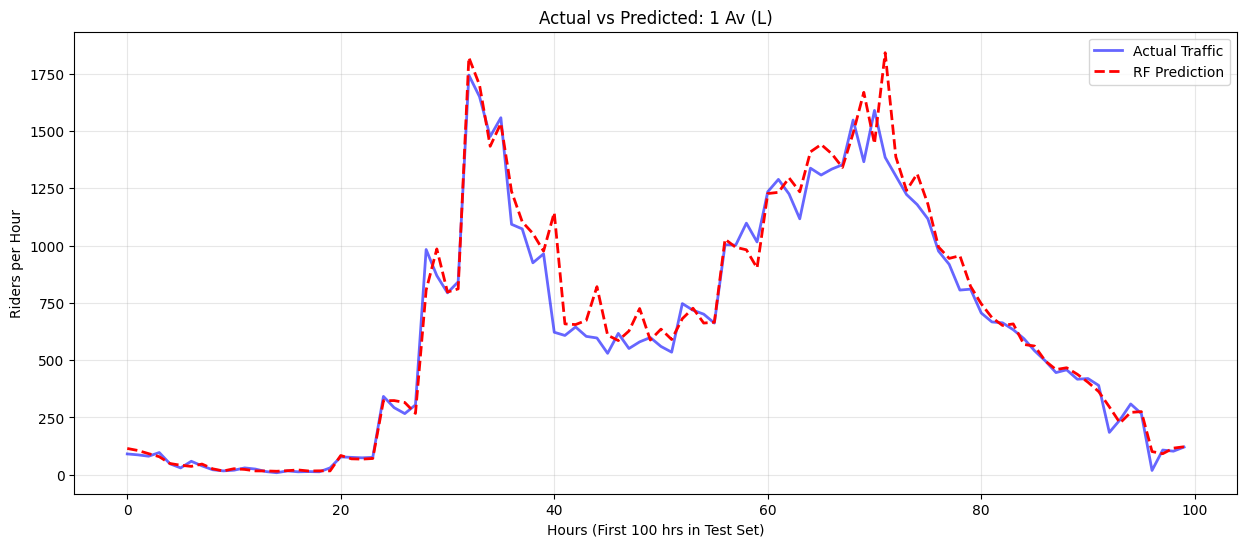

In [23]:
station_cols = [col for col in df.columns if col.startswith('sta_')]
target_station_col = station_cols[0]  

test_indices = df[df['month'] > 10].index
results_df = df.loc[test_indices].copy()

results_df['Actual'] = y_test_rf  
results_df['Predicted'] = pred   


subset = results_df[results_df[target_station_col] == 1]
subset = subset.sort_values(by=['month', 'weekday', 'hour'])
station_name = target_station_col.replace('sta_', '')

plt.figure(figsize=(15, 6))
plt.plot(subset['Actual'].values[:100], label='Actual Traffic', color='blue', alpha=0.6, linewidth=2)
plt.plot(subset['Predicted'].values[:100], label='RF Prediction', color='red', linestyle='--', linewidth=2)

plt.title(f"Actual vs Predicted: {station_name}")
plt.xlabel("Hours (First 100 hrs in Test Set)")
plt.ylabel("Riders per Hour")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [24]:
# basic neural network
early_stopping = EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=3, verbose=1)

# Input Layer
model_nn = Sequential()

model_nn.add(Dense(256, input_dim = X_train.shape[1], activation = 'relu'))
model_nn.add(BatchNormalization())
model_nn.add(Dropout(0.3))

model_nn.add(Dense(128, activation = 'relu'))
model_nn.add(Dropout(0.2))

model_nn.add(Dense(64, activation = 'relu'))
model_nn.add(Dense(1, activation = 'linear'))

model_nn.compile(loss='mean_absolute_error', optimizer='adam')
history_nn = model_nn.fit(X_train, y_train_nn, epochs = 100, batch_size = 64, 
                    validation_data = (X_test, y_test_nn), callbacks = [early_stopping, lr_scheduler], verbose = 1)

/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/core/dense.py:95: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Epoch 1/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 6s 933us/step - loss: 0.0290 - val_loss: 0.0163 - learning_rate: 0.0010
Epoch 2/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 4s 791us/step - loss: 0.0098 - val_loss: 0.0097 - learning_rate: 0.0010
Epoch 3/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 4s 781us/step - loss: 0.0083 - val_loss: 0.0083 - learning_rate: 0.0010
Epoch 4/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 4s 777us/step - loss: 0.0076 - val_loss: 0.0077 - learning_rate: 0.0010
Epoch 5/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 4s 769us/step - loss: 0.0073 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 6/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 5s 839us/step - loss: 0.0070 - val_loss: 0.0084 - learning_rate: 0.0010
Epoch 7/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 4s 776us/step - loss: 0.0068 - val_loss: 0.0075 - learning_rate: 0.0010
Epoch 8/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 4s 802us/step - loss: 0.0067 - val_loss: 0.0082 - learning_rate: 0.0010
Epoch 9/100
5569/5569 ━━━━━━━━━━━━━━━━━━━━ 4s 776us/step - loss: 0.0066 - val_lo

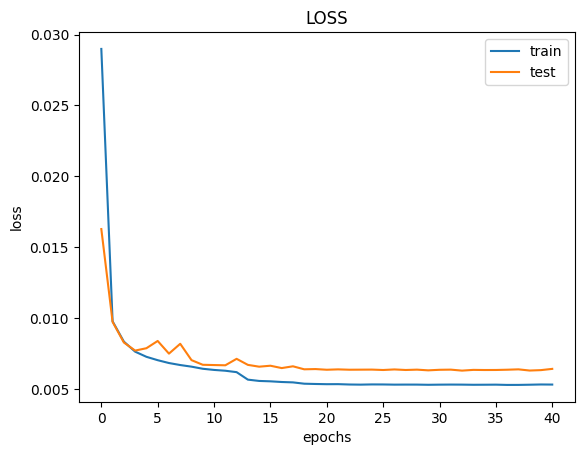

In [25]:
plt.plot(history_nn.history['loss'], label = 'train')
plt.plot(history_nn.history['val_loss'], label = 'test')
plt.legend()
plt.title('LOSS')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.show()

In [26]:
# GRU model - time step = 1 since the data already consider previous data through lag columns 
X_train_gru = X_train.reshape(X_train.shape[0], 1, X_train.shape[1])
X_test_gru = X_test.reshape(X_test.shape[0], 1, X_test.shape[1])

early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)
lr_scheduler = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, verbose=1)

model_gru = Sequential()

model_gru.add(GRU(128, return_sequences=False, input_shape=(1, X_train.shape[1])))
model_gru.add(Dropout(0.1))

model_gru.add(Dense(64, activation='relu'))
model_gru.add(Dropout(0.05)) 

model_gru.add(Dense(32, activation='relu'))
model_gru.add(Dense(1, activation='linear'))

model_gru.compile(loss='mean_absolute_error', optimizer='adam')

history_gru = model_gru.fit(
    X_train_gru, y_train_nn, 
    epochs=100, 
    batch_size=256, 
    validation_data=(X_test_gru, y_test_nn), 
    callbacks=[early_stopping, lr_scheduler], 
    verbose=1
)

Epoch 1/100


/opt/anaconda3/envs/tf_env/lib/python3.10/site-packages/keras/src/layers/rnn/rnn.py:199: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


1393/1393 ━━━━━━━━━━━━━━━━━━━━ 4s 2ms/step - loss: 0.0080 - val_loss: 0.0079 - learning_rate: 0.0010
Epoch 2/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0058 - val_loss: 0.0066 - learning_rate: 0.0010
Epoch 3/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0054 - val_loss: 0.0064 - learning_rate: 0.0010
Epoch 4/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0052 - val_loss: 0.0063 - learning_rate: 0.0010
Epoch 5/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0050 - val_loss: 0.0062 - learning_rate: 0.0010
Epoch 6/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0049 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 7/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0048 - val_loss: 0.0060 - learning_rate: 0.0010
Epoch 8/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0047 - val_loss: 0.0059 - learning_rate: 0.0010
Epoch 9/100
1393/1393 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step - loss: 0.0046 - val_loss: 0.0062 - learning_rate: 0.

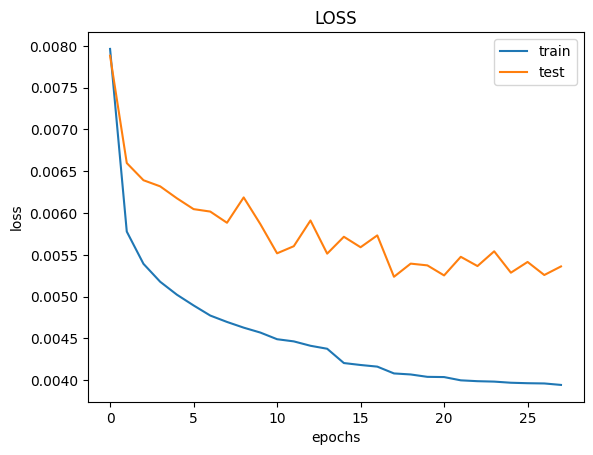

In [27]:
plt.plot(history_gru.history['loss'], label = 'train')
plt.plot(history_gru.history['val_loss'], label = 'test')
plt.legend()
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('LOSS')
plt.show()

In [28]:
import pandas as pd
import numpy as np
from sklearn.metrics import mean_absolute_error, r2_score

y_pred_rf = rf.predict(X_test)

pred_nn_scaled = model_nn.predict(X_test, verbose=0)
y_pred_nn = scale_y.inverse_transform(pred_nn_scaled)

pred_gru_scaled = model_gru.predict(X_test_gru, verbose=0)
y_pred_gru = scale_y.inverse_transform(pred_gru_scaled)

y_true = y_test_rf.flatten()
y_pred_rf = y_pred_rf.flatten()
y_pred_nn = y_pred_nn.flatten()
y_pred_gru = y_pred_gru.flatten()

predictions_dict = {
    "Random Forest": y_pred_rf,
    "Dense NN": y_pred_nn,
    "GRU": y_pred_gru
}

results_list = []

for name, preds in predictions_dict.items():
    mae = mean_absolute_error(y_true, preds)
    r2 = r2_score(y_true, preds)
    
    results_list.append({
        "Model": name,
        "MAE (Real Riders)": round(mae, 2),
        "R2 Score": round(r2, 4)
    })

comparison_df = pd.DataFrame(results_list)
comparison_df = comparison_df.sort_values(by="MAE (Real Riders)", ascending=True)

print("champion")
print(comparison_df.to_string(index=False))

winner = comparison_df.iloc[0]["Model"]
print(f"\nWinner is {winner}")

champion
        Model  MAE (Real Riders)  R2 Score
          GRU             105.64    0.9770
Random Forest             122.66    0.9656
     Dense NN             126.75    0.9704

Winner is GRU


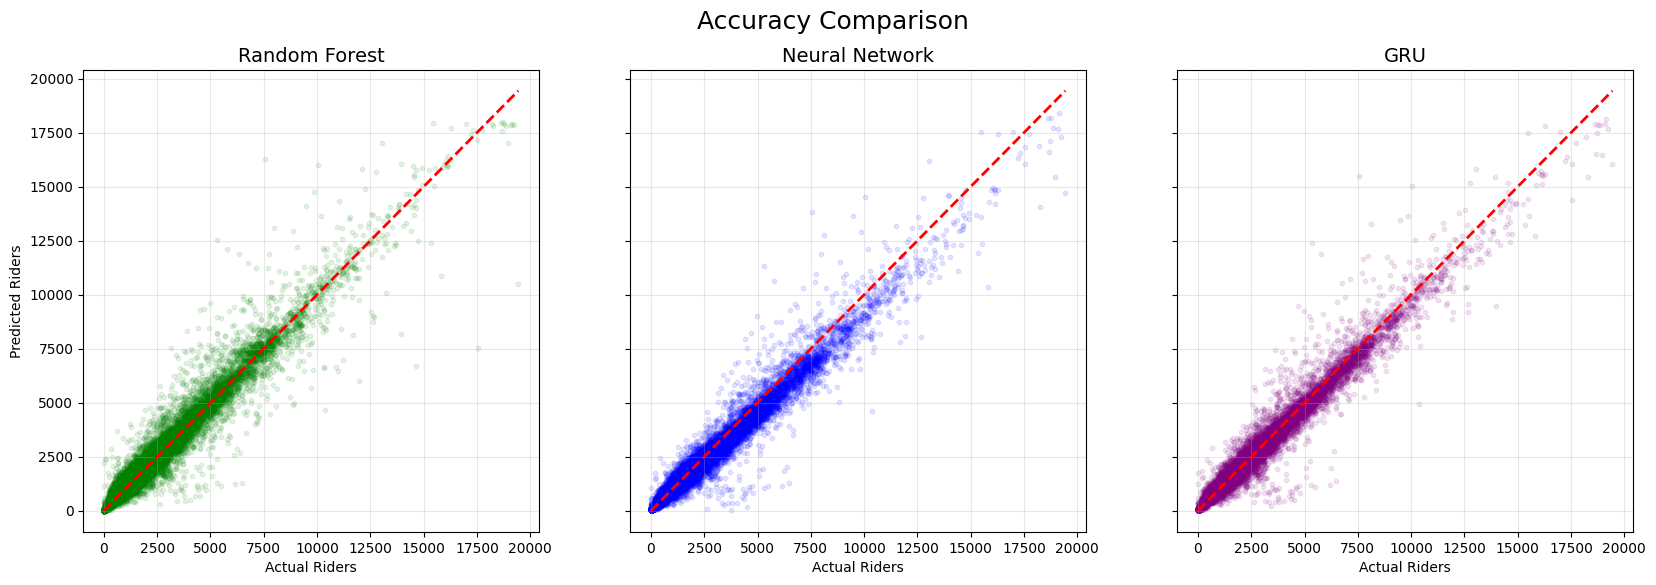

In [29]:
import matplotlib.pyplot as plt

fig, axes = plt.subplots(1, 3, figsize=(20, 6), sharey=True)

def plot_scatter(ax, y_true, y_pred, title, color):
    y_true = y_true.flatten()
    y_pred = y_pred.flatten()
    
    ax.scatter(y_true, y_pred, alpha=0.1, color=color, s=10)
    
    max_val = max(y_true.max(), y_pred.max())
    ax.plot([0, max_val], [0, max_val], 'r--', lw=2)
    
    ax.set_title(title, fontsize=14)
    ax.set_xlabel('Actual Riders')
    ax.grid(True, alpha=0.3)

y_test_real = scale_y.inverse_transform(y_test_nn)

plot_scatter(axes[0], y_test_rf, y_pred_rf, 'Random Forest', 'green')
axes[0].set_ylabel('Predicted Riders')

plot_scatter(axes[1], y_test_real, y_pred_nn, 'Neural Network', 'blue')

plot_scatter(axes[2], y_test_real, y_pred_gru, 'GRU', 'purple')

plt.suptitle('Accuracy Comparison', fontsize=18)
plt.show()

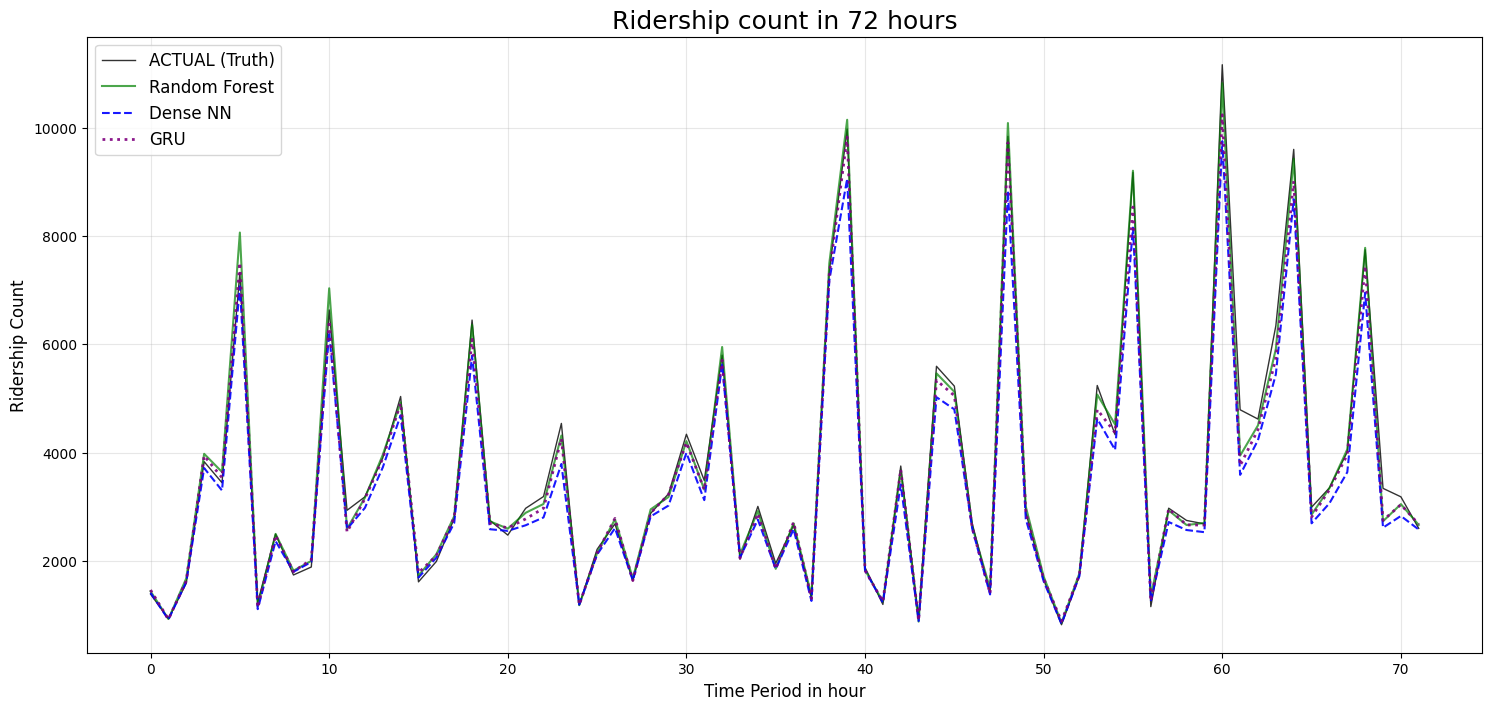

In [30]:
import matplotlib.pyplot as plt

y_actual = y_true 
p_rf = y_pred_rf
p_nn = y_pred_nn
p_gru = y_pred_gru 

start = 2000
end = 2072

plt.figure(figsize=(18, 8))

plt.plot(y_actual[start:end], label='ACTUAL (Truth)', color='black', linewidth=1, alpha=0.8)

plt.plot(p_rf[start:end], label='Random Forest', color='green', linestyle='-', linewidth=1.5, alpha=0.7)
plt.plot(p_nn[start:end], label='Dense NN', color='blue', linestyle='--', linewidth=1.5, alpha=0.9)
plt.plot(p_gru[start:end], label='GRU', color='purple', linestyle=':', linewidth=2, alpha=0.9)

plt.title(f'Ridership count in {end - start} hours', fontsize=18)
plt.ylabel('Ridership Count', fontsize=12)
plt.xlabel('Time Period in hour', fontsize=12)
plt.legend(fontsize=12, loc='upper left')
plt.grid(True, alpha=0.3)

plt.show()

In [ ]:
#